Ce notebook a pour objectif de faire la jointure entre le dvf et les données de Géorisques, c'est-à-dire les données de risques d'inondation.

In [6]:
import requests
import pandas as pd
import os
import gzip
import shutil
import geopandas as gpd

from shapely.geometry import Point


In [5]:
def charger_donnees(chemin_fichier):
    """
    Charge un fichier CSV dans un DataFrame pandas.
    :param chemin_fichier: Chemin du fichier CSV
    :return: DataFrame contenant les données du CSV
    """
    df = pd.read_csv(chemin_fichier)
    df['nombre_dependances'] = df['nombre_dependances'].fillna(0)
    return df

df_initial = charger_donnees("/home/onyxia/work/projet_statapp_inondations-3/DVFfinal.csv")

In [34]:
def construction_geo_df(df):

    
    #création d'une colonne geometrie
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # conversion du dataframe en geodataframe
    geo_df = gpd.GeoDataFrame(df, geometry='geometry')
    #changement de projection (2154)
    geo_df = geo_df.set_crs("EPSG:4326", allow_override=True, inplace=True)
    geo_df = geo_df.to_crs("EPSG:2154")

    return geo_df



def recuperation_fichier_shp(chemin):

    zone_risque = gpd.read_file(chemin)
    #conversion de la projection des departements en lambert-93 (epsg 2154)
    zone_risque = zone_risque.to_crs(epsg=2154)


    # Définir les bornes de la zone Aude, Gard et Hérault en Lambert 93 (EPSG:2154)
    x_min = 500000
    x_max = 800000
    y_min = 6200000
    y_max = 6450000


    # Filtrer les zones de risque
    zone_risque = zone_risque.cx[x_min:x_max, y_min:y_max]
    return zone_risque


def jointure_spatiale(geo_df, zone_risque,nom_risque):

    # Réinitialiser l'index pour éviter les doublons

    jointure = gpd.sjoin(geo_df, zone_risque, how='left', predicate='intersects')
    jointure = jointure.reset_index(drop=True)
    geo_df[nom_risque] = jointure['index_right'].notna().astype(int)

    return geo_df


geo_df_initial =construction_geo_df(df_initial)

In [35]:
zone_risque_debordement_for = recuperation_fichier_shp("/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_01for_s.shp")

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_01for_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [36]:
geo_df_test = jointure_spatiale(geo_df_initial,zone_risque_debordement_for,"risque_debordement_fort")

In [37]:
geo_df_test.head()

,Unnamed: 0.1,Unnamed: 0,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,...,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_maison,nombre_dependances,prix_terrain,geometry,risque_debordement_fort
0,0,0,2019-202011,2019-07-01,1,Vente,161000.0,15.0,NaN,RUE PAUL GAUGUIN,...,80.0,3.0,203.0,4.316416,43.759404,161000.000000,0.0,161000.000000,POINT (806025.516 6296481.88),0
1,1,1,2019-202020,2019-07-04,1,Vente,539920.0,1781.0,NaN,RTE DE SAUVE,...,100.0,4.0,319.0,4.195975,43.859824,220375.510204,0.0,79334.168586,POINT (796156.84 6307485.445),0
2,2,2,2019-202020,2019-07-04,1,Vente,539920.0,1781.0,NaN,RTE DE SAUVE,...,60.0,3.0,319.0,4.195975,43.859824,132225.306122,0.0,79334.168586,POINT (796156.84 6307485.445),0
3,3,3,2019-202020,2019-07-04,1,Vente,539920.0,1821.0,NaN,RTE DE SAUVE,...,85.0,3.0,1533.0,4.195750,43.859556,187319.183673,0.0,381251.662828,POINT (796139.202 6307455.394),0
4,4,4,2019-202021,2019-07-01,1,Vente,99000.0,5264.0,NaN,LA BOUISSONADE ET MONBLADI,...,84.0,3.0,2480.0,NaN,NaN,99000.000000,0.0,99000.000000,POINT (NaN NaN),0


/tmp/ipykernel_134297/1444170641.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


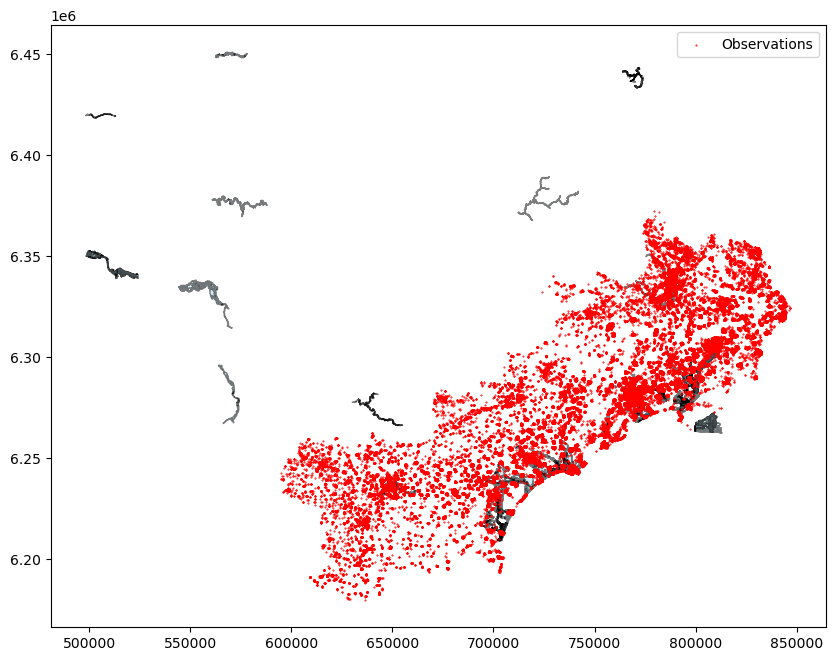

In [45]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
zone_risque_debordement_for.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Zones de risque')
geo_df_test.plot(ax=ax, color='red', markersize=0.2, label='Observations')
plt.legend()
plt.show()

/tmp/ipykernel_134297/4152974181.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


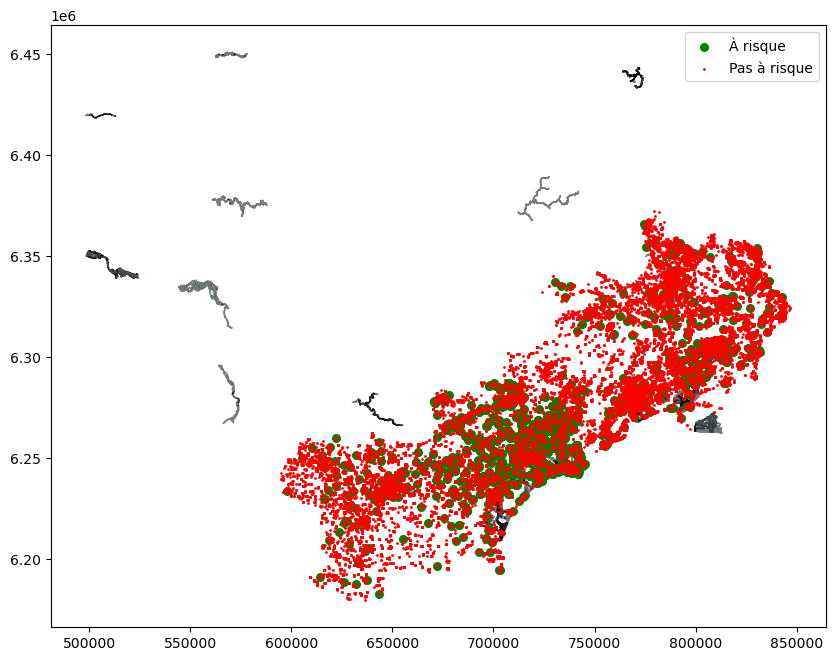

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
zone_risque_debordement_for.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Zones de risque')
geo_df_test[geo_df_test['risque_debordement_fort'] == 1].plot(ax=ax, color='green', markersize=30, label='À risque')
geo_df_test[geo_df_test['risque_debordement_fort'] == 0].plot(ax=ax, color='red', markersize=1, label='Pas à risque')
plt.legend()
plt.show()

### Maintenant que l'on a testé pour une variable, on va le faire pour les 8 autres risques 


On boucle nos fonctions pour cumuler les risques, à chaque fois, on crée une nouvelle colonne dans notre dataframe

In [53]:
geo_df_initial = construction_geo_df(df_initial)

def ajouter_colonnes_risque(geo_df, fichiers_shp):
    """
    Ajoute une colonne pour chaque fichier shp indiquant si l'observation est dans une zone à risque.
    :param df: GeoDataFrame avec les observations (incluant longitude et latitude)
    :param fichiers_shp: Dictionnaire avec le nom de la colonne en clé et le chemin du fichier .shp en valeur
    :return: GeoDataFrame avec les colonnes de risques ajoutées
    """
    for nom_risque, chemin_shp in fichiers_shp.items():
        print("\n nouveau risque !")
        zone_risque = recuperation_fichier_shp(chemin_shp)
        geo_df = jointure_spatiale(geo_df, zone_risque, nom_risque)

    return geo_df

fichiers_shp = {
    'risque_debordement_fort': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_01for_s.shp',
    'risque_debordement_moyen': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_02moy_s.shp',
    'risque_debordement_faible': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_04fai_s.shp',
    'risque_submersion_fort': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_03_01for_s.shp',
    'risque_submersion_moyen': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_03_02moy_s.shp',
    'risque_submersion_faible': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_03_04fai_s.shp',
    'risque_ruissellement_fort': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_02_01for_s.shp',
    'risque_ruissellement_moyen': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_02_02moy_s.shp',
    'risque_ruissellement_faible': '/home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_02_04fai_s.shp'
}




In [54]:
geo_df_complet = ajouter_colonnes_risque(geo_df_initial,fichiers_shp)


 nouveau risque !


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_01for_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



 nouveau risque !


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_02moy_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



 nouveau risque !


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_01_04fai_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



 nouveau risque !


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_03_01for_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



 nouveau risque !


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_03_02moy_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



 nouveau risque !


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_03_04fai_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



 nouveau risque !

 nouveau risque !


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/projet_statapp_inondations-3/data/n_inondable_02_02moy_s.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(



 nouveau risque !


In [57]:
geo_df_complet.head(10)

,Unnamed: 0.1,Unnamed: 0,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,...,geometry,risque_debordement_fort,risque_debordement_moyen,risque_debordement_faible,risque_submersion_fort,risque_submersion_moyen,risque_submersion_faible,risque_ruissellement_fort,risque_ruissellement_moyen,risque_ruissellement_faible
0,0,0,2019-202011,2019-07-01,1,Vente,161000.00,15.0,NaN,RUE PAUL GAUGUIN,...,POINT (806025.516 6296481.88),0,0,0,0,0,0,0,0,0
1,1,1,2019-202020,2019-07-04,1,Vente,539920.00,1781.0,NaN,RTE DE SAUVE,...,POINT (796156.84 6307485.445),0,0,0,0,0,0,0,0,0
2,2,2,2019-202020,2019-07-04,1,Vente,539920.00,1781.0,NaN,RTE DE SAUVE,...,POINT (796156.84 6307485.445),0,0,0,0,0,0,0,0,0
3,3,3,2019-202020,2019-07-04,1,Vente,539920.00,1821.0,NaN,RTE DE SAUVE,...,POINT (796139.202 6307455.394),0,0,0,0,0,0,0,0,0
4,4,4,2019-202021,2019-07-01,1,Vente,99000.00,5264.0,NaN,LA BOUISSONADE ET MONBLADI,...,POINT (NaN NaN),0,0,0,0,0,0,0,0,0
5,5,5,2019-202026,2019-07-01,1,Vente,228222.00,122.0,NaN,RTE DE MARIGNAC,...,POINT (804211.851 6328275.59),0,0,0,0,0,0,0,0,0
6,6,6,2019-202027,2019-07-01,1,Vente,380500.00,9.0,NaN,IMP DES SALADELLES,...,POINT (796941.524 6275577.539),0,1,1,0,1,1,0,0,0
7,7,7,2019-202036,2019-07-05,1,Vente,1119600.00,2.0,NaN,IMP DE LA PHALENE,...,POINT (804264.532 6304840.224),0,0,0,0,0,0,0,0,0
8,8,8,2019-202045,2019-07-04,1,Vente,420800.25,10.0,NaN,CHE DU CIMETIERE VIEUX,...,POINT (798856.319 6301147.762),0,0,0,0,0,0,0,0,0
9,9,9,2019-202047,2019-07-02,1,Vente,176000.00,5288.0,NaN,CHE DU MAS DE PIAN,...,POINT (790272.297 6314948.129),0,0,0,0,0,0,0,0,0


In [ ]:
#On exporte le DVF complet

if geo_df_complet.crs.to_string() != 'EPSG:4326':
    geo_df_complet = geo_df_complet.to_crs(epsg=4326)

# 2. Extraire les coordonnées
geo_df_complet['longitude'] = geo_df_complet.geometry.x
geo_df_complet['latitude'] = geo_df_complet.geometry.y

# 3. Supprimer la colonne géométrique (optionnel)
geo_df_complet = geo_df_complet.drop(columns='geometry')


AttributeError: 'DataFrame' object has no attribute 'crs'

In [63]:
geo_df_complet.to_csv('DVF_avec_risques_inondations.csv', index=False)

In [64]:
#On teste juste si l'export est valide

df_final = pd.read_csv("/home/onyxia/work/projet_statapp_inondations-3/DVF_avec_risques_inondations.csv")

df_final.head()

,Unnamed: 0.1,Unnamed: 0,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,...,prix_terrain,risque_debordement_fort,risque_debordement_moyen,risque_debordement_faible,risque_submersion_fort,risque_submersion_moyen,risque_submersion_faible,risque_ruissellement_fort,risque_ruissellement_moyen,risque_ruissellement_faible
0,0,0,2019-202011,2019-07-01,1,Vente,161000.0,15.0,NaN,RUE PAUL GAUGUIN,...,161000.000000,0,0,0,0,0,0,0,0,0
1,1,1,2019-202020,2019-07-04,1,Vente,539920.0,1781.0,NaN,RTE DE SAUVE,...,79334.168586,0,0,0,0,0,0,0,0,0
2,2,2,2019-202020,2019-07-04,1,Vente,539920.0,1781.0,NaN,RTE DE SAUVE,...,79334.168586,0,0,0,0,0,0,0,0,0
3,3,3,2019-202020,2019-07-04,1,Vente,539920.0,1821.0,NaN,RTE DE SAUVE,...,381251.662828,0,0,0,0,0,0,0,0,0
4,4,4,2019-202021,2019-07-01,1,Vente,99000.0,5264.0,NaN,LA BOUISSONADE ET MONBLADI,...,99000.000000,0,0,0,0,0,0,0,0,0
